# Лабораторная работ №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

###### Выполнил: Попов Владимир Дмитриевич
###### Группа: М8О-307Б-23
###### Датасет (ссылка): [Электрички](https://www.kaggle.com/datasets/alamshihab075/electric-vehicle-population-dataset) 

---

# Задание:

0. Выбрать модель для обучения (Desicion tree, Random forest, SVM, KNN, Boosting)
1. Показать какие гиперпараметры есть у выбранной модели (В виде таблички).
2. Выбрать датасет для обучения и взависимости от модели подготовить данные
3. Подобрать гиперпараметры для модели и сравнить лучшие подборы, для (Grid Search, RandomSearch, Optuna)
4. На самом лучшем обучении (Grid Search, RandomSearch, Optuna) сделать калькулятор, который показывает `локальную интерпретацию` с помощью [LIME](https://habr.com/ru/companies/otus/articles/779430/) и `глобальную интерпретацию` с помощью [SHAP](https://habr.com/ru/companies/ods/articles/599573/).

    [Доп статья](https://habr.com/ru/companies/wunderfund/articles/739744/)

# Формат сдачи

1. Защита преподавателю
2. Презентация о проделанной работе (10-15 слайдов)
3. Файл `FIO_lr3.ibynb`

# Выбор модели и таблица гиперпараметров

Для выполнения задания была выбрана модель XGBoost (Extreme Gradient Boosting) — продвинутая реализация градиентного бустинга,
где каждое следующее дерево учится на ошибках предыдущих.

Гиперпараметр	| Описание	                                        | Возможные значения / Диапазон
----------------|---------------------------------------------------|------------------------------
n_estimators	|Количество деревьев в ансамбле	                    |int: 50-1000
max_depth       |Максимальная глубина дерева	                    |int: 3-12 (None для без ограничений)
learning_rate	|Скорость обучения (шаг градиентного спуска)        |float: 0.01-0.3
subsample       |Доля образцов для обучения каждого дерева          |float: 0.5-1.0	
colsample_bytree|Доля признаков для каждого дерева                  |float: 0.5-1.0
gamma	        |Минимальное уменьшение потерь для разделения узла	|float: 0-10	
reg_alpha	    |L1 регуляризация (Lasso)	                        |float: 0-10
reg_lambda	    |L2 регуляризация (Ridge)	                        |float: 0-10	

# Загрузим датасет

Этот датасет объединяет записи о регистрации электромобилей на уровне VIN и атрибуты транспортных средств для более чем 264 тыс. записей. Каждая строка описывает зарегистрированный электромобиль (или подключаемый гибрид) и включает частичный VIN (VIN (1-10)), год выпуска, марку и модель, тип электромобиля (BEV или PHEV), запас хода на электротяге (мили), базовую рекомендованную розничную цену (MSRP), примечания о соответствии требованиям для автомобилей на чистом альтернативном топливе (CAFV), геокодированное местоположение автомобиля (геометрия POINT), электроэнергетическую компанию и участок переписи 2020 года

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('Electric_Vehicle_Population_Data.csv')

print(f"Размер датасета: {df.shape}")
print(df.head())

Размер датасета: (264628, 17)
   VIN (1-10)     County     City State  Postal Code  Model Year    Make  \
0  WA1E2AFY8R   Thurston  Olympia    WA      98512.0        2024    AUDI   
1  WAUUPBFF4J     Yakima   Wapato    WA      98951.0        2018    AUDI   
2  1N4AZ0CP0F       King  Seattle    WA      98125.0        2015  NISSAN   
3  WA1VAAGE5K       King     Kent    WA      98031.0        2019    AUDI   
4  7SAXCAE57N  Snohomish  Bothell    WA      98021.0        2022   TESLA   

     Model                   Electric Vehicle Type  \
0     Q5 E  Plug-in Hybrid Electric Vehicle (PHEV)   
1       A3  Plug-in Hybrid Electric Vehicle (PHEV)   
2     LEAF          Battery Electric Vehicle (BEV)   
3   E-TRON          Battery Electric Vehicle (BEV)   
4  MODEL X          Battery Electric Vehicle (BEV)   

   Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0              Not eligible due to low battery range            23.0   
1              Not eligible due to low batte

# 2. Предобработка данных

In [98]:
# Пропущенные значения
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Пропущено': missing_data,
    'Процент': missing_percent
})
print(missing_df[missing_df['Пропущено'] > 0])

                      Пропущено   Процент
County                        9  0.003401
City                          9  0.003401
Postal Code                   9  0.003401
Electric Range                4  0.001512
Base MSRP                     4  0.001512
Legislative District        659  0.249029
Vehicle Location             17  0.006424
Electric Utility              9  0.003401
2020 Census Tract             9  0.003401


# Визуализация распределений

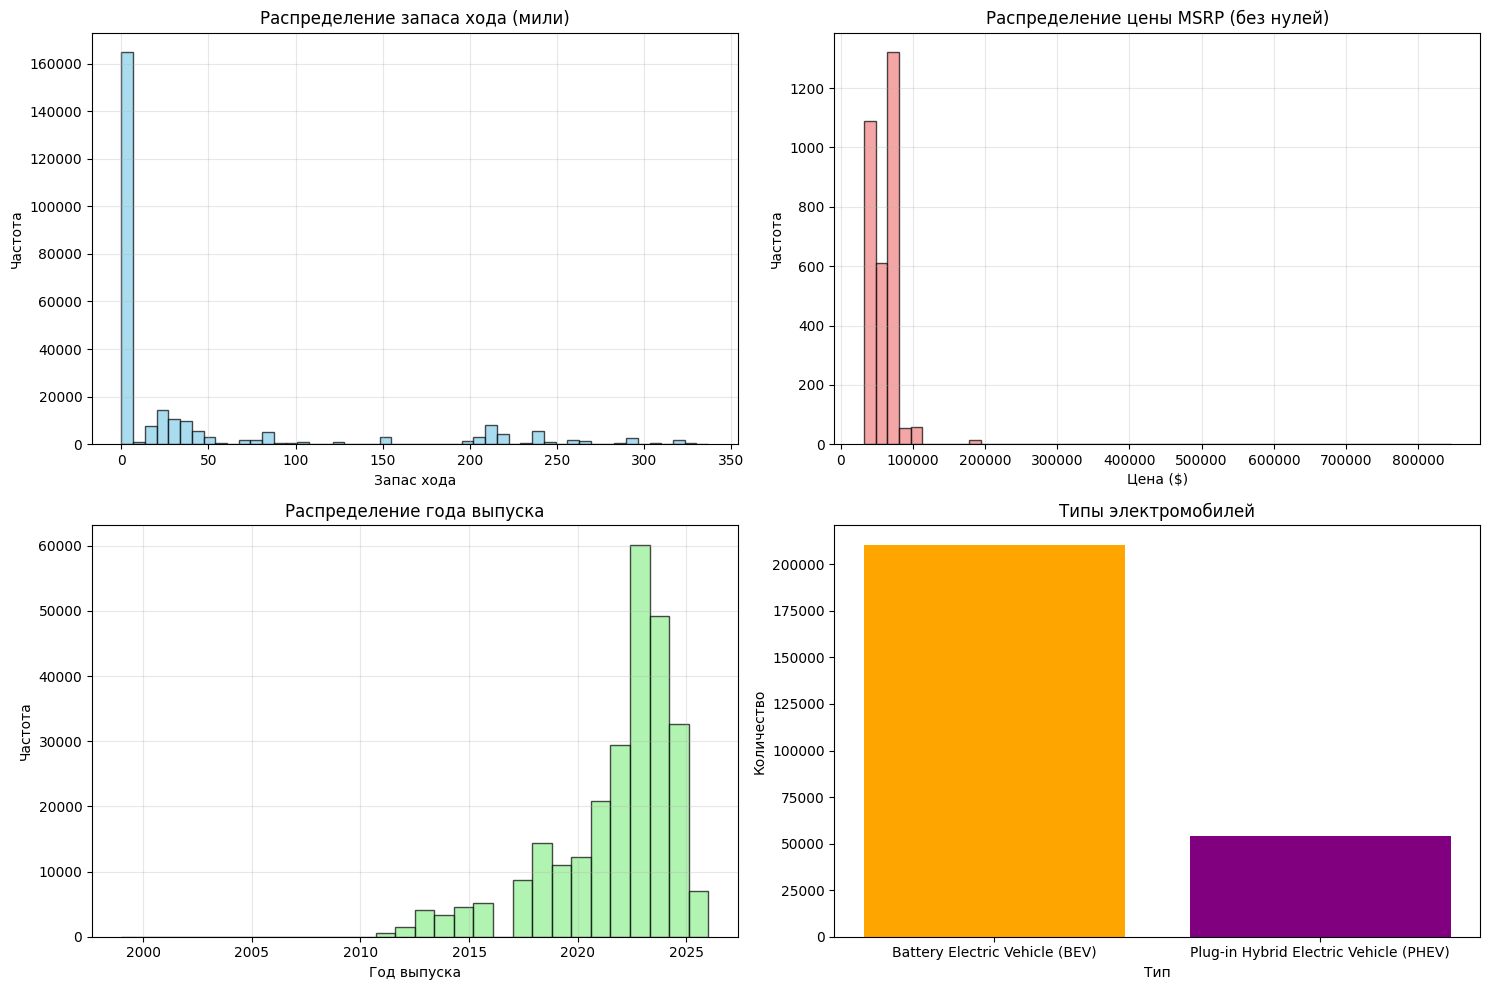

In [99]:
def plot_feature_distributions(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Electric Range
    electric_range_clean = df['Electric Range'].dropna()
    axes[0, 0].hist(electric_range_clean, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Распределение запаса хода (мили)')
    axes[0, 0].set_xlabel('Запас хода')
    axes[0, 0].set_ylabel('Частота')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Base MSRP (без нулей)
    msrp_clean = df['Base MSRP'].replace(0, np.nan).dropna()
    axes[0, 1].hist(msrp_clean, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Распределение цены MSRP (без нулей)')
    axes[0, 1].set_xlabel('Цена ($)')
    axes[0, 1].set_ylabel('Частота')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Model Year
    axes[1, 0].hist(df['Model Year'].dropna(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 0].set_title('Распределение года выпуска')
    axes[1, 0].set_xlabel('Год выпуска')
    axes[1, 0].set_ylabel('Частота')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Electric Vehicle Type
    ev_type_counts = df['Electric Vehicle Type'].value_counts()
    axes[1, 1].bar(ev_type_counts.index, ev_type_counts.values, color=['orange', 'purple'])
    axes[1, 1].set_title('Типы электромобилей')
    axes[1, 1].set_xlabel('Тип')
    axes[1, 1].set_ylabel('Количество')
    
    plt.tight_layout()
    plt.show()

plot_feature_distributions(df)

In [101]:
# Удаление строк с нулевыми значениями в ключевых признаках
initial_shape = df.shape
df = df[(df['Electric Range'] > 0) & (df['Base MSRP'] > 0)]

# Удаление ненужных колонок
columns_to_drop = ['VIN (1-10)', 'Legislative District', 'DOL Vehicle ID']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Заполнение пропусков
df['Electric Range'] = df['Electric Range'].fillna(df['Electric Range'].median())
df = df.dropna()

# Feature Engineering

In [104]:
from sklearn.preprocessing import LabelEncoder


df['Vehicle Age'] = 2025 - df['Model Year']

# Категории запаса хода
df['Range Category'] = pd.cut(df['Electric Range'],
                              bins=[-1, 100, 200, 300, float('inf')],
                              labels=['Short', 'Medium', 'Long', 'Very Long'])

# Признак роскошного бренда
luxury_brands = ['Tesla', 'Audi', 'BMW', 'Mercedes-Benz', 'Porsche', 'Jaguar']
df['Is Luxury Brand'] = df['Make'].isin(luxury_brands)

# Кодирование категориальных признаков
categorical_cols = ['Make', 'Model', 'Electric Vehicle Type', 'Range Category']
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col].astype(str))

# Корреляция

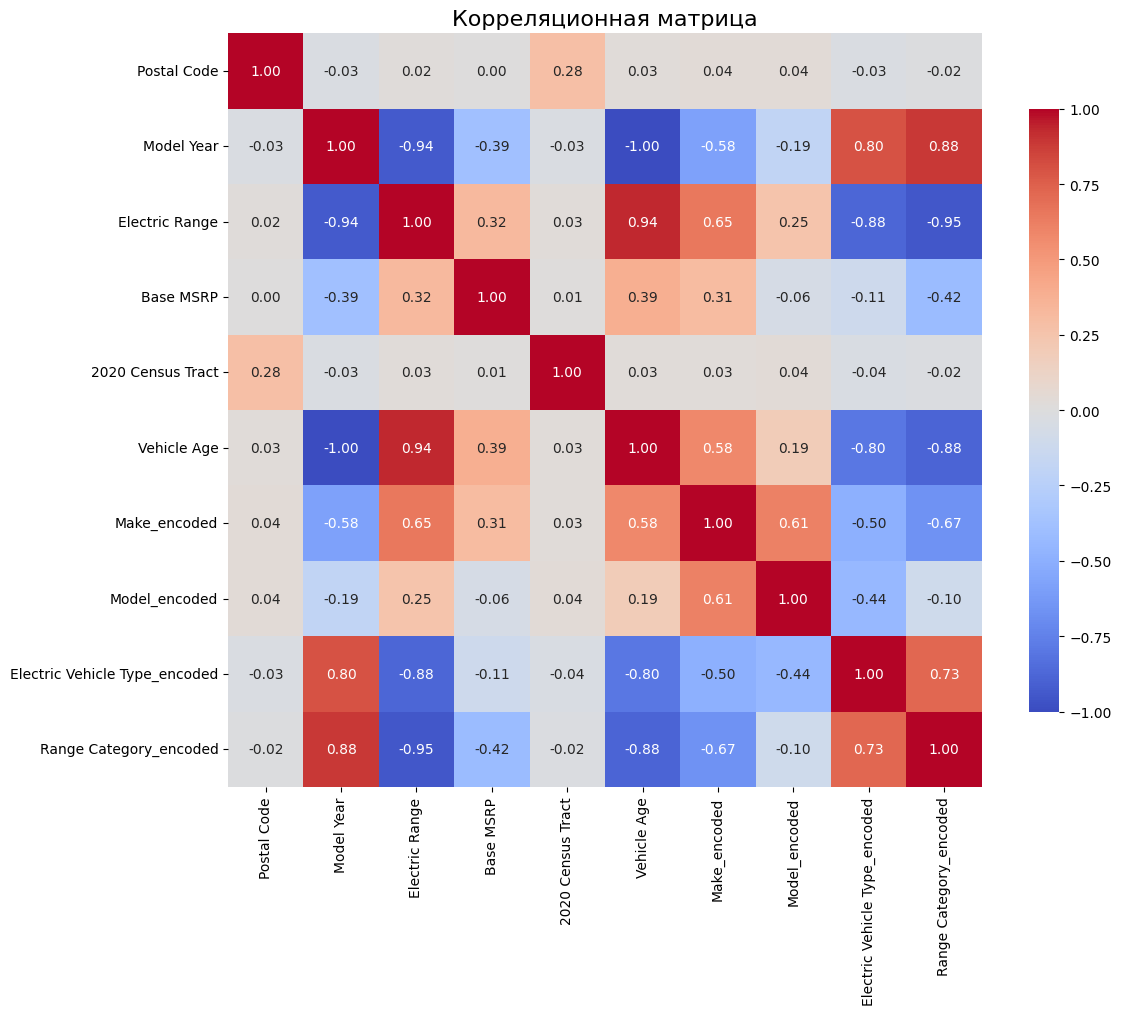

In [ ]:
def draw_corr_matrix(df):
    """Построение корреляционной матрицы"""
    numeric_df = df.select_dtypes(include=['number'])
    
    plt.figure(figsize=(12, 10))
    corr = numeric_df.corr()
    
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        square=True,
        cbar_kws={"shrink": .8}
    )
    plt.title("Корреляционная матрица", fontsize=16)
    plt.tight_layout()
    plt.show()

draw_corr_matrix(df)

# Обработка выбросов

In [106]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    
    return df_clean


numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
df = remove_outliers_iqr(df, numeric_cols)

# Подготовка данных для модели

In [ ]:
from sklearn.model_selection import train_test_split


target = 'Base MSRP'
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col != target]

model_df = df[numeric_features + [target]].dropna()

Обучающая выборка: (1979, 9)
Тестовая выборка: (495, 9)


# Разделение на train/test

In [108]:
X = model_df[numeric_features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Подбор гиперпараметров

In [85]:
!pip install optuna


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Grid Search
- Перебирает все возможные комбинации указанных гиперпараметров.
- Для каждой комбинации обучает модель и проверяет качество на кросс-валидации.
- Возвращает лучшую комбинацию по заданной метрике (например, accuracy).

In [111]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
import optuna

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Лучший R²: {grid_search.best_score_:.4f}")
print(f"Лучшие параметры: {grid_search.best_params_}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Лучший R²: 0.9868
Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


# Random Search

* **Идея:** выбираем случайные комбинации гиперпараметров из заранее определённых диапазонов.
* **Плюсы:**
  * Прост в реализации.
  * Эффективнее, чем Grid Search для моделей с большим числом гиперпараметров.
  * Хорош для грубой оценки влияния гиперпараметров.
* **Минусы:**
  * Не гарантирует нахождение оптимального решения.
  * Требует большого числа итераций при сложных пространствах гиперпараметров.


In [137]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 10),
    'reg_alpha': uniform(0, 10),
    'reg_lambda': uniform(0, 10)
}

random_search = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_dist,
    n_iter=50,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)
print(f"Лучший R²: {random_search.best_score_:.4f}")
print(f"Лучшие параметры: ")
j = 0
for i in random_search.best_params_.keys():
    print(f"{i}: {random_search.best_params_[i]}", end = ', ')
    if j % 4 == 0:
        print()
    j += 1

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучший R²: 0.9920
Лучшие параметры: 
colsample_bytree: 0.6390688456025535, 
gamma: 6.842330265121569, learning_rate: 0.1420457481218804, max_depth: 9, n_estimators: 363, 
reg_alpha: 0.34388521115218396, reg_lambda: 9.093204020787821, subsample: 0.7035119926400067, 

# Байесовская оптимизация с Optuna

* **Идея:** строим вероятностную модель функции потерь и используем её, чтобы выбирать новые гиперпараметры «умнее», чем случайно.
* **Плюсы:**
  * Эффективнее Random Search при сложных пространствах гиперпараметров.
  * Балансирует *exploration* (исследование) и *exploitation* (использование лучших областей).
* **Минусы:**
  * Сложнее для понимания и настройки.
  * Требует больше зависимостей (Optuna, иногда PyTorch/Scikit-learn).

[Подробнее](https://optuna.org/)

In [140]:
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }
    
    model = xgb.XGBRegressor(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='r2')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Лучший R²: {study.best_value:.4f}")
print(f"Лучшие параметры: {study.best_params}")

[I 2025-12-07 20:54:43,519] A new study created in memory with name: no-name-90c9d09b-2963-4afb-9dec-2b0cbdac5842
[I 2025-12-07 20:54:44,066] Trial 0 finished with value: 0.9874734793870892 and parameters: {'n_estimators': 298, 'max_depth': 6, 'learning_rate': 0.0665575194878673, 'subsample': 0.7940597945079559, 'colsample_bytree': 0.9691180734940789, 'gamma': 4.595945693696148, 'reg_alpha': 4.003605270486568, 'reg_lambda': 7.77810745439869}. Best is trial 0 with value: 0.9874734793870892.
[I 2025-12-07 20:54:44,264] Trial 1 finished with value: 0.9894991085638117 and parameters: {'n_estimators': 132, 'max_depth': 10, 'learning_rate': 0.12392704231456125, 'subsample': 0.666135607294985, 'colsample_bytree': 0.8554238954401245, 'gamma': 0.592194010287227, 'reg_alpha': 2.657213149180423, 'reg_lambda': 4.630722400024245}. Best is trial 1 with value: 0.9894991085638117.
[I 2025-12-07 20:54:44,597] Trial 2 finished with value: 0.9917376334982286 and parameters: {'n_estimators': 273, 'max_dep

Лучший R²: 0.9923
Лучшие параметры: {'n_estimators': 192, 'max_depth': 4, 'learning_rate': 0.11530506403378428, 'subsample': 0.8609522266203155, 'colsample_bytree': 0.640745090259403, 'gamma': 2.82391605902394, 'reg_alpha': 0.09974351114088487, 'reg_lambda': 5.886835150474556}


# Сравнение результатов

In [116]:
from sklearn.metrics import r2_score, mean_squared_error


results = {
    'GridSearch': {'score': grid_search.best_score_, 'params': grid_search.best_params_},
    'RandomSearch': {'score': random_search.best_score_, 'params': random_search.best_params_},
    'Optuna': {'score': study.best_value, 'params': study.best_params}
}

for method, res in results.items():
    print(f"{method:15} R² = {res['score']:.4f}")


best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print(f"R² score: {test_r2:.4f}")
print(f"RMSE: ${test_rmse:,.0f}")

GridSearch      R² = 0.9868
RandomSearch    R² = 0.9920
Optuna          R² = 0.9924
РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:
R² score: 1.0000
RMSE: $51


# Интерпретация модели

In [117]:
!pip install lime shap -q

import lime
import lime.lime_tabular
import shap


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# LIME - локальная интерпретация

In [123]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    mode='regression',
    verbose=False
)

sample_idx = 0
sample = X_test.iloc[sample_idx]
actual_price = y_test.iloc[sample_idx]
predicted_price = best_model.predict(sample.values.reshape(1, -1))[0]

print(f"\nПример #{sample_idx}:")
print(f"Реальная цена: ${actual_price:,.0f}")
print(f"Предсказанная цена: ${predicted_price:,.0f}")
print(f"Ошибка: ${abs(predicted_price - actual_price):,.0f}")

exp = explainer_lime.explain_instance(
    sample.values,
    best_model.predict,
    num_features=10
)

print("\nОбъяснение предсказания (ТОП-10 признаков):")
print("="*60)


exp_list = exp.as_list()

for feature, weight in exp_list:
    print(f"{feature:40} → {weight:+.4f}")

print("\n" + "="*60)
print("Интерпретация:")

positive_features = [(f, w) for f, w in exp_list if w > 0]
negative_features = [(f, w) for f, w in exp_list if w < 0]

if positive_features:
    print("\nПризнаки, УВЕЛИЧИВАЮЩИЕ предсказание:")
    for feature, weight in positive_features[:5]:
        print(f"  • {feature}: +{weight:.3f}")

if negative_features:
    print("\nПризнаки, УМЕНЬШАЮЩИЕ предсказание:")
    for feature, weight in negative_features[:5]:
        print(f"  • {feature}: {weight:.3f}")

lime_predicted_price = predicted_price


Пример #0:
Реальная цена: $69,900
Предсказанная цена: $69,899
Ошибка: $1

Объяснение предсказания (ТОП-10 признаков):
7.00 < Vehicle Age <= 11.00              → -10214.6724
4.00 < Make_encoded <= 8.00              → -9567.4769
32.00 < Electric Range <= 208.00         → -5984.0065
Model_encoded <= 9.00                    → +2701.4954
Range Category_encoded <= 0.00           → +888.7170
2013.00 < Model Year <= 2014.00          → +778.1558
Electric Vehicle Type_encoded <= 0.00    → -443.2241
2020 Census Tract > 53053072408.00       → -18.8624
Postal Code > 98334.00                   → -7.4239

Интерпретация:

Признаки, УВЕЛИЧИВАЮЩИЕ предсказание:
  • Model_encoded <= 9.00: +2701.495
  • Range Category_encoded <= 0.00: +888.717
  • 2013.00 < Model Year <= 2014.00: +778.156

Признаки, УМЕНЬШАЮЩИЕ предсказание:
  • 7.00 < Vehicle Age <= 11.00: -10214.672
  • 4.00 < Make_encoded <= 8.00: -9567.477
  • 32.00 < Electric Range <= 208.00: -5984.007
  • Electric Vehicle Type_encoded <= 0.00: -443

# SHAP - Глобальная интерпретация

Вычисляем SHAP значения...
Рассмотрено 100 примеров из тестовой выборки

1. Summary Plot (важность признаков):


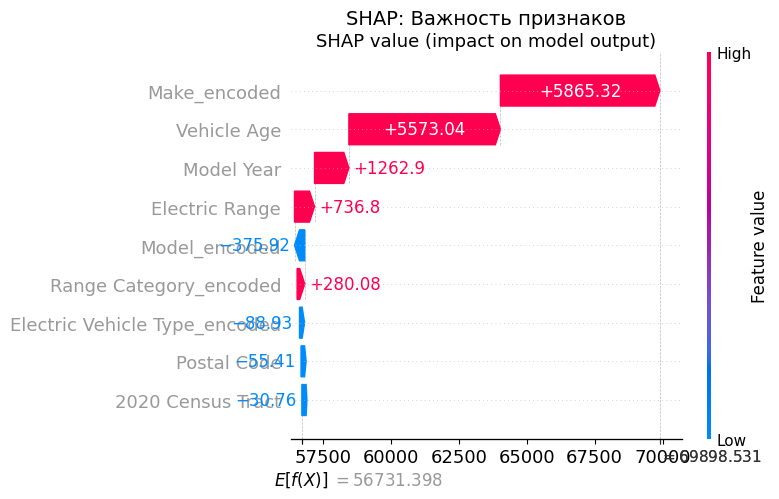


2. Bar Plot (средняя абсолютная важность):


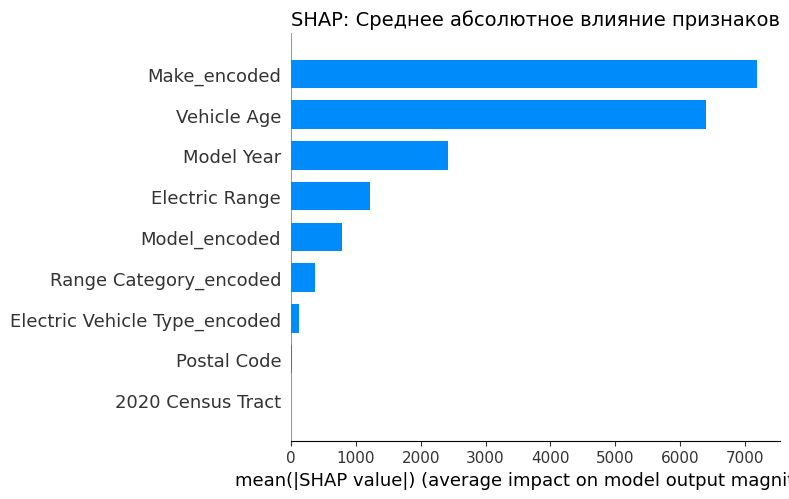


3. Dependence Plots для самых важных признаков:
  1. Make_encoded


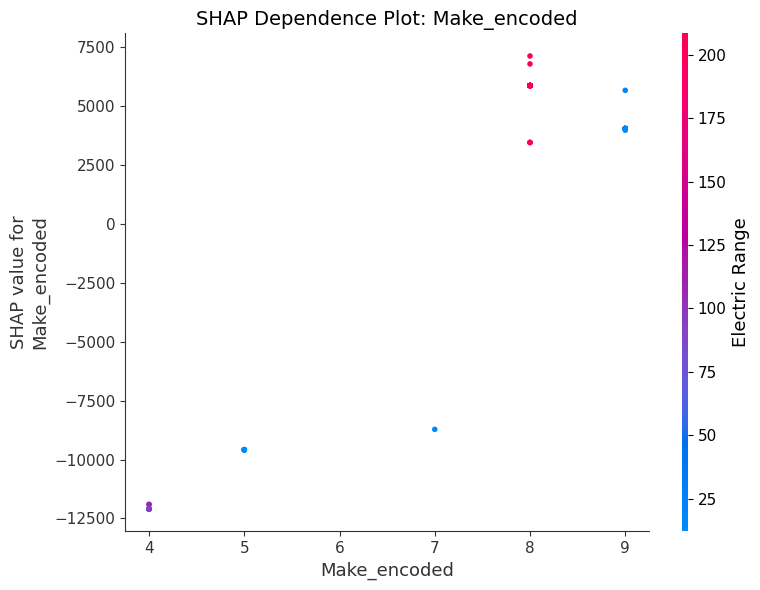

  2. Vehicle Age


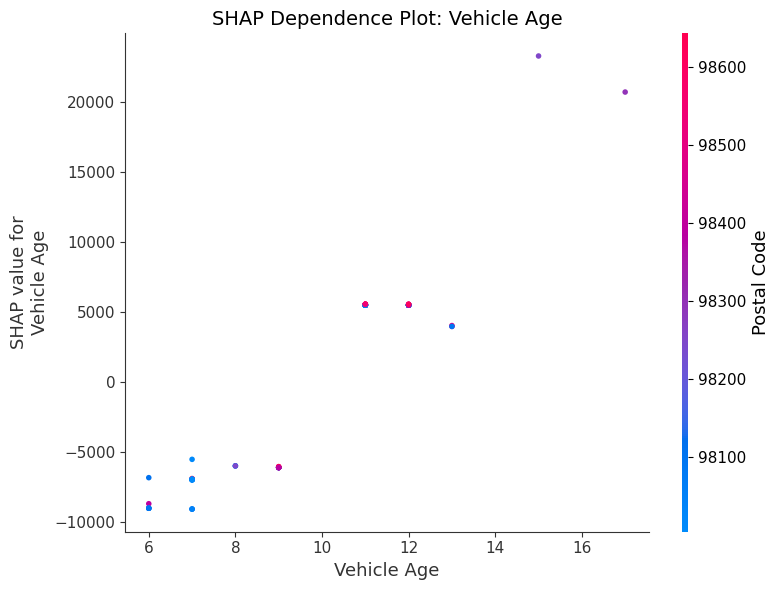

  3. Model Year


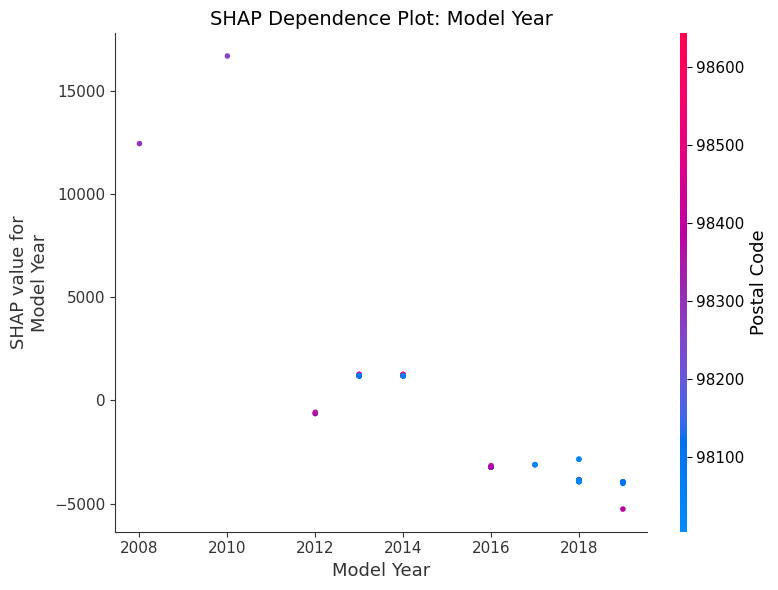


4. Waterfall Plot для примера #0:


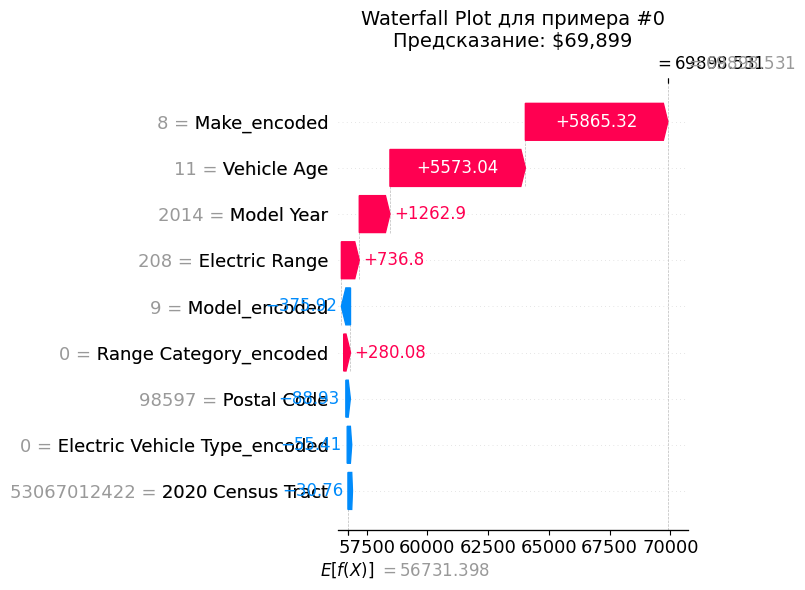


5. Beeswarm Plot (распределение влияний):


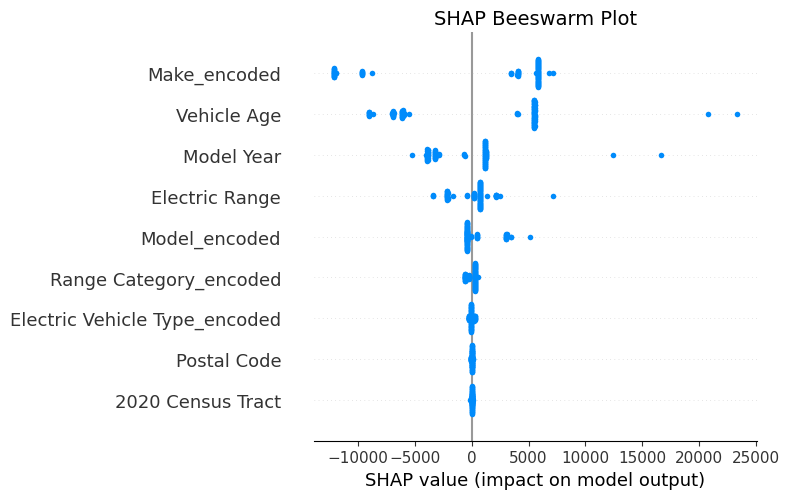

Базовое значение (expected value): $56,731
Среднее абсолютное влияние по признакам:
                      Признак  SHAP_важность
                 Make_encoded    7178.656738
                  Vehicle Age    6395.799805
                   Model Year    2426.657715
               Electric Range    1212.933960
                Model_encoded     795.915466
       Range Category_encoded     372.194458
Electric Vehicle Type_encoded     121.294571
                  Postal Code      18.901405
            2020 Census Tract       6.782192


In [124]:
explainer_shap = shap.TreeExplainer(best_model)

print("Вычисляем SHAP значения...")
sample_size = min(100, len(X_test))
X_test_sample = X_test.iloc[:sample_size]
shap_values = explainer_shap.shap_values(X_test_sample)

print(f"Рассмотрено {sample_size} примеров из тестовой выборки")

print("\n1. Summary Plot (важность признаков):")
shap.summary_plot(shap_values, X_test_sample, feature_names=X_train.columns, show=False)
plt.title("SHAP: Важность признаков", fontsize=14)
plt.tight_layout()
plt.show()


print("\n2. Bar Plot (средняя абсолютная важность):")
shap.summary_plot(shap_values, X_test_sample, feature_names=X_train.columns, plot_type="bar", show=False)
plt.title("SHAP: Среднее абсолютное влияние признаков", fontsize=14)
plt.tight_layout()
plt.show()

# 3. Dependence plot для топ-3 признаков
print("\n3. Dependence Plots для самых важных признаков:")

# Определяем топ-3 самых важных признаков
shap_abs_mean = np.abs(shap_values).mean(0)
top_3_indices = np.argsort(shap_abs_mean)[-3:][::-1]
top_3_features = X_train.columns[top_3_indices]

for i, feature in enumerate(top_3_features, 1):
    print(f"  {i}. {feature}")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    shap.dependence_plot(
        feature,
        shap_values,
        X_test_sample,
        feature_names=X_train.columns,
        ax=ax,
        show=False
    )
    plt.title(f"SHAP Dependence Plot: {feature}", fontsize=14)
    plt.tight_layout()
    plt.show()

# 4. Waterfall plot для примера
print("\n4. Waterfall Plot для примера #0:")

# Создаем waterfall plot
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer_shap.expected_value,
        data=X_test_sample.iloc[0],
        feature_names=X_train.columns.tolist()
    ),
    show=False
)
plt.title(f"Waterfall Plot для примера #0\nПредсказание: ${predicted_price:,.0f}", fontsize=14)
plt.tight_layout()
plt.show()

# 5. Beeswarm plot (альтернатива summary plot)
print("\n5. Beeswarm Plot (распределение влияний):")
shap.plots.beeswarm(
    shap.Explanation(
        values=shap_values,
        base_values=explainer_shap.expected_value,
        feature_names=X_train.columns.tolist()
    ),
    show=False
)
plt.title("SHAP Beeswarm Plot", fontsize=14)
plt.tight_layout()
plt.show()

print(f"Базовое значение (expected value): ${explainer_shap.expected_value:,.0f}")
print(f"Среднее абсолютное влияние по признакам:")

feature_importance_shap = pd.DataFrame({
    'Признак': X_train.columns,
    'SHAP_важность': np.abs(shap_values).mean(0)
}).sort_values('SHAP_важность', ascending=False)

print(feature_importance_shap.head(10).to_string(index=False))